<a href="https://colab.research.google.com/github/LuannSantoss/Sales-Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#importing dataset
dataset = pd.read_csv('mock_kaggle.csv')
dataset.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [3]:
dataset.shape

(937, 4)

In [4]:
#getting rid of columns that will not be used for this forecast (inventory and prices)
dataset = dataset.drop(['estoque','preco'], axis=1)

In [5]:
dataset.describe()

,venda
count,937.000000
mean,90.533618
std,80.682089
min,0.000000
25%,33.000000
50%,76.000000
75%,127.000000
max,542.000000


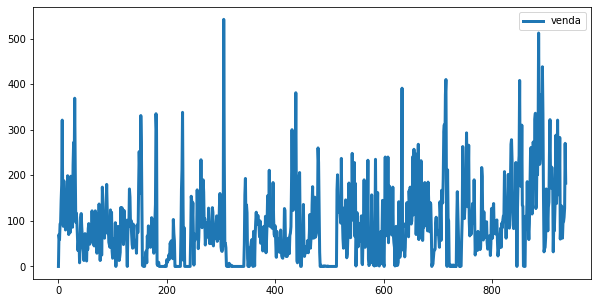

In [6]:
#plotting sales over time (daily)
dataset.plot(figsize=(10,5),
            linewidth = 3)

In [7]:
dataset.dtypes

data     object
venda     int64
dtype: object

In [8]:
#changing date for datetime format
dataset['data'] = pd.to_datetime(dataset['data'])

In [9]:
dataset.dtypes

data     datetime64[ns]
venda             int64
dtype: object

In [10]:
#in order to predict 3 weeks of sales ahead of the most recent data, sales will be grouped by week
dataset = dataset.groupby(pd.Grouper(key='data', freq='W')).sum()

In [11]:
dataset

,venda
data,
2014-01-05,318
2014-01-12,1167
2014-01-19,748
2014-01-26,838
2014-02-02,1500
...,...
2016-07-03,1237
2016-07-10,990
2016-07-17,1431


In [12]:
#resetting index
dataset = dataset.reset_index()

In [13]:
dataset.shape

(135, 2)

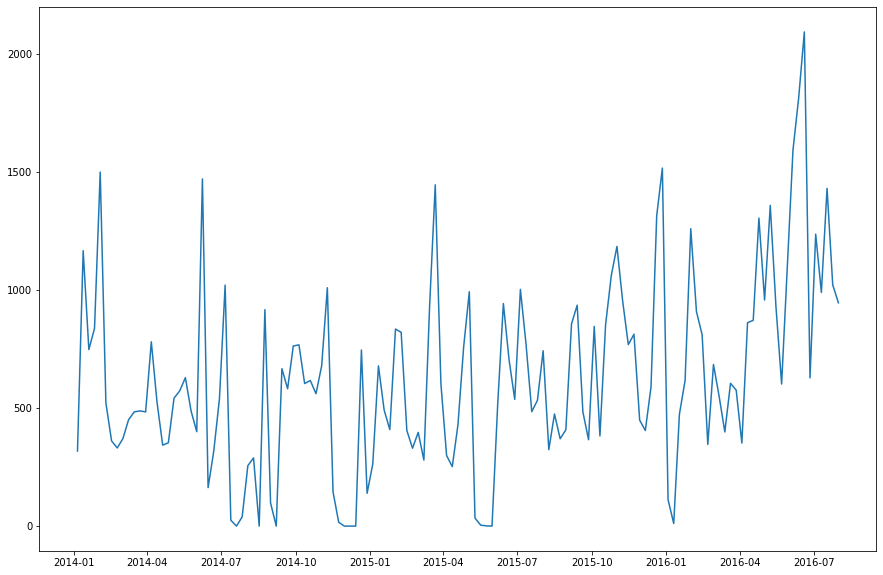

In [14]:
#plotting sales by week
plt.figure(figsize=(15,10))
plt.plot(dataset['data'], dataset['venda'])

In [15]:
#for validating predictors, we will use the last 3 recorded sales data to compare with predictions. Then, we will calculate RMSE between prediction and validation to check which method is better for this case
split_point = len(dataset) - 3

In [16]:
#training data and validation data
dados_treino = dataset[0:split_point]
dados_validacao = dataset[split_point:]

In [17]:
#size of training data and validation data
print('tamanho: dados_treino %d, dados_validacao %d' % (len(dados_treino), len(dados_validacao)))

tamanho: dados_treino 132, dados_validacao 3


#Using Prophet

In [18]:
#the first method will be fbprophet
from fbprophet import Prophet

In [19]:
dados_treino

,data,venda
0,2014-01-05,318
1,2014-01-12,1167
2,2014-01-19,748
3,2014-01-26,838
4,2014-02-02,1500
...,...,...
127,2016-06-12,1814
128,2016-06-19,2094
129,2016-06-26,628
130,2016-07-03,1237


In [20]:
#for Prophet, it is required to have columns renamed to "ds" and "y" 
dados_treino = dados_treino.rename(columns = {'data': 'ds', 'venda': 'y'}, inplace = False)

In [21]:
#multiplicative indicates that seasonality may be higher or lower than for each new season
model = Prophet(seasonality_mode = 'multiplicative')

In [22]:
model.fit(dados_treino)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
futuro = model.make_future_dataframe(periods = 3, freq = 'W')

In [24]:
saida = model.predict(futuro)

In [25]:
#yhat is the prediction. Meanwhile yhat_lower and yhat_upper are inferior and superior limits, respectively
saida[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-05,267.830379,-156.854184,668.593645
1,2014-01-12,238.176490,-172.719085,675.047833
2,2014-01-19,366.068531,-57.796593,739.675796
3,2014-01-26,556.285348,176.371228,964.294532
4,2014-02-02,647.825961,233.758179,1035.933665
...,...,...,...,...
130,2016-07-03,962.780440,548.692320,1359.308241
131,2016-07-10,853.123824,451.099207,1252.827431
132,2016-07-17,780.554404,374.201487,1199.787728
133,2016-07-24,666.418483,266.216302,1045.681781


In [26]:
dados_validacao = dados_validacao.rename(columns = {'data': 'ds', 'venda': 'y'}, inplace = False)

In [27]:
validation = pd.DataFrame({'ds': dados_validacao['ds']})
validation2 = pd.DataFrame({'ds': dados_validacao['ds']})

In [28]:
validation['ds']

132   2016-07-17
133   2016-07-24
134   2016-07-31
Name: ds, dtype: datetime64[ns]

In [29]:
validation2

,ds
132,2016-07-17
133,2016-07-24
134,2016-07-31


In [30]:
validation2.loc[135] = pd.to_datetime('2016-08-07')
validation2.loc[136] = pd.to_datetime('2016-08-14')
validation2.loc[137] = pd.to_datetime('2016-08-21')

In [31]:
validation2

,ds
132,2016-07-17
133,2016-07-24
134,2016-07-31
135,2016-08-07
136,2016-08-14
137,2016-08-21


In [32]:
validation

,ds
132,2016-07-17
133,2016-07-24
134,2016-07-31


In [33]:
saida = model.predict(validation)
saida2 = model.predict(validation2)

In [34]:
saida[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2016-07-17,780.554404,382.324805,1171.267883
1,2016-07-24,666.418483,275.583970,1094.148860
2,2016-07-31,530.972658,131.319257,922.312705


In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(dados_validacao['y'].values, saida.yhat))
print('Test RMSE: %.3f' %rmse)

Test RMSE: 490.498


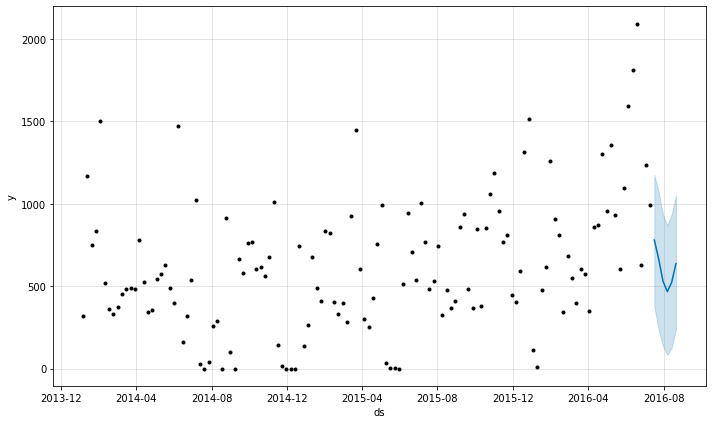

In [36]:
figura = model.plot(saida2)

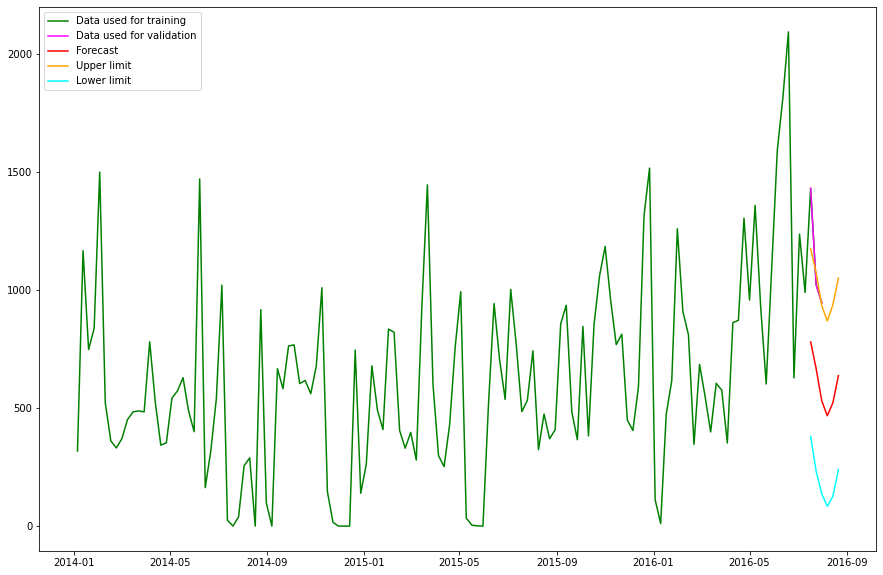

In [37]:
plt.figure(figsize=(15,10))
plt.plot(dataset['data'], dataset['venda'], c='green', label='Data used for training')
plt.plot(dados_validacao['ds'], dados_validacao['y'], c='fuchsia', label='Data used for validation')
plt.plot(saida2['ds'], saida2['yhat'], c='red', label='Forecast')
plt.plot(saida2['ds'], saida2['yhat_upper'], c='orange', label='Upper limit')
plt.plot(saida2['ds'], saida2['yhat_lower'], c='cyan', label='Lower limit')
plt.legend(loc='best')
plt.show()

In [38]:
saida2[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2016-07-17,780.554404,379.587898,1175.639817
1,2016-07-24,666.418483,231.625240,1072.453433
2,2016-07-31,530.972658,136.769358,934.091815
3,2016-08-07,467.519769,83.554228,869.090148
4,2016-08-14,522.347402,126.013888,936.987344
5,2016-08-21,637.279268,238.570336,1050.490903


In [39]:
print('Sales forecast for next 3 weeks: ')
for i in range(3,6):
  print(int(saida2['yhat'][i]))
for i in range(3,6):
  print('In week', i-2,'sales can vary between', int(saida2['yhat_lower'][i]),'and',int(saida2['yhat_upper'][i]))

Sales forecast for next 3 weeks: 
467
522
637
In week 1 sales can vary between 83 and 869
In week 2 sales can vary between 126 and 936
In week 3 sales can vary between 238 and 1050


# Using ARIMA

In [40]:
#for the second predictor, we will use ARIMA
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
dataset = pd.read_csv('mock_kaggle.csv')
dataset = dataset.drop(['estoque','preco'], axis=1)
dataset['data'] = pd.to_datetime(dataset['data'])
dataset = dataset.groupby(pd.Grouper(key='data', freq='W')).sum()

In [41]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 3.7 MB/s 
     |████████████████████████████████| 9.5 MB 28.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [42]:
from pmdarima.arima import auto_arima

In [43]:
stepwise_model = auto_arima(dataset, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal = True, d=1,D=1, trace = True, error_action='ignore', suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1893.573, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1855.435, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1857.180, Time=0.95 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1859.854, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1859.178, Time=1.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1861.209, Time=0.46 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1869.040, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1827.747, Time=0.78 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1829.728, Time=1.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1834.570, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1829.715, Time=1.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,1)(2

In [44]:
print(stepwise_model.aic())

1817.992093045448


In [45]:
dataset

,venda
data,
2014-01-05,318
2014-01-12,1167
2014-01-19,748
2014-01-26,838
2014-02-02,1500
...,...
2016-07-03,1237
2016-07-10,990
2016-07-17,1431


In [46]:
split_point = len(dataset) - 3
dados_treino = dataset[0:split_point]
dados_validacao = dataset[split_point:]

In [47]:
stepwise_model.fit(dados_treino)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [48]:
dados_futuros = stepwise_model.predict(n_periods=3)
dados_futuros = pd.DataFrame(dados_futuros, index = dados_validacao.index, columns=['venda'])

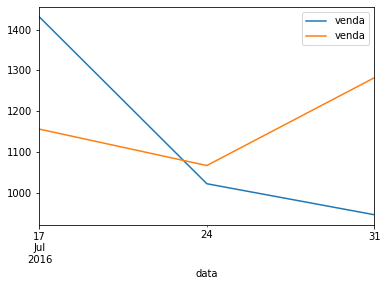

In [49]:
#validation data vs predicted data
pd.concat([dados_validacao, dados_futuros], axis=1).plot()

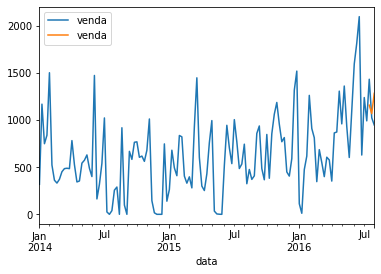

In [50]:
pd.concat([dataset, dados_futuros], axis=1).plot()

In [51]:
#since this RMSE was lower than the previous one, ARIMA is the best predictor in this case
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(dados_validacao['venda'].values, dados_futuros['venda']))
print('Test RMSE: %.3f' %rmse)

Test RMSE: 251.978


In [52]:
#3 weeks ahead
future = ['2016-08-07','2016-08-14','2016-08-21']

In [53]:
future_forecast = stepwise_model.predict(n_periods=3)
future_forecast = pd.DataFrame(future_forecast, index = future, columns=['venda'])

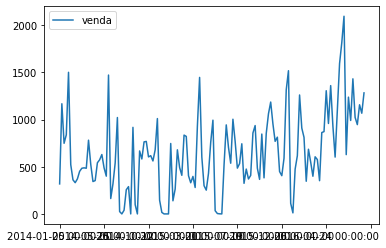

In [54]:
pd.concat([dataset, future_forecast], axis=0).plot()

In [55]:
dataset = dataset.reset_index()

In [56]:
future_forecast = future_forecast.reset_index()

In [57]:
future_forecast['index'] = pd.to_datetime(future_forecast['index'])

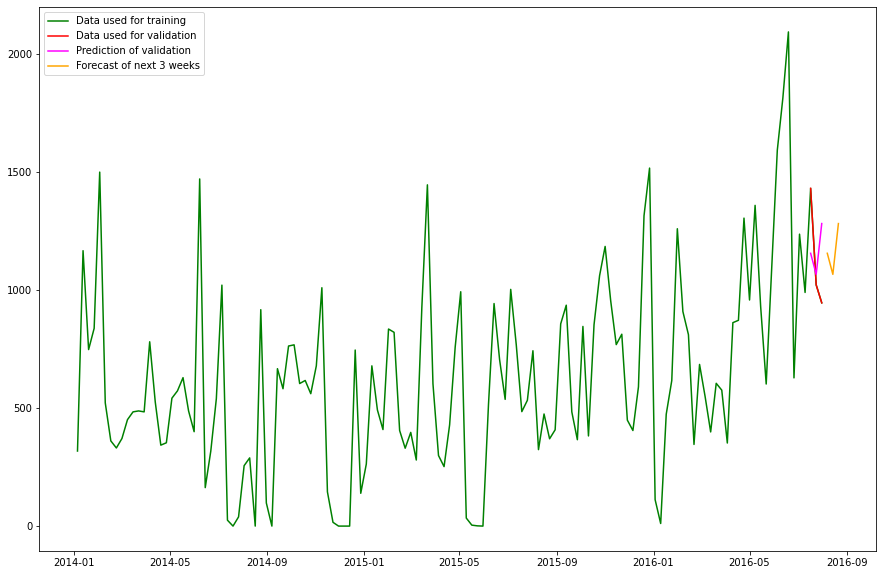

In [58]:
plt.figure(figsize=(15,10))
plt.plot(dataset['data'], dataset['venda'], c='green', label='Data used for training')
plt.plot(dados_validacao, c='red', label='Data used for validation')
plt.plot(dados_futuros, c='fuchsia', label='Prediction of validation')
plt.plot(future_forecast['index'], future_forecast['venda'], c='orange', label='Forecast of next 3 weeks')
plt.legend(loc='best')
plt.show()

In [69]:
#this is the most accurate prediction
print('Sales forecast for next 3 weeks: ')
for i in future_forecast['venda']:
  print(round(i))
for i in range(0,3):
  print('In week', i+1,'sales can vary between', int(future_forecast['venda'][i]-rmse),'and',int(future_forecast['venda'][i]+rmse))

Sales forecast for next 3 weeks: 
1156
1067
1282
In week 1 sales can vary between 904 and 1407
In week 2 sales can vary between 814 and 1318
In week 3 sales can vary between 1029 and 1533
